In [96]:

from __future__ import annotations

import os
import logging
from pathlib import Path
from typing import List, Dict, Any

import numpy as np
import pypdf
import lancedb
from lancedb.pydantic import LanceModel, Vector
from dotenv import load_dotenv
from google import genai
import logging
from typing import TypedDict, List
from langgraph.graph import StateGraph, END, START
from langchain.schema import Document
import dspy

### Reading from the JD PDFs

In [97]:
import os
import logging
from pathlib import Path
from typing import List, Dict, Any
import pypdf

load_dotenv()
LANCE_URI = os.getenv("LANCE_URI")
LANCE_API_KEY = os.getenv("LANCE_API_KEY")
LANCE_REGION = os.getenv("LANCE_REGION")
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
DOCS_FOLDER = os.getenv("DOCS_FOLDER", "docs/JD")  # fallback if not set
LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_API_KEY"] = LANGSMITH_API_KEY 
os.environ["LANGSMITH_TRACING"] = "true" 


from google import genai
client = genai.Client(api_key=GEMINI_API_KEY)
EMBEDDINGS_MODEL_ID = "gemini-embedding-001"


logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

llm = dspy.LM("gemini/gemini-2.5-flash", api_key=GEMINI_API_KEY)
dspy.configure(lm=llm)

class RAGState(TypedDict):
    query: str
    docs: List[Document]
    context: str
    answer: str
    plan: dict
    candidate_ids: List[str]
    candidates_context: str     # NEW
    candidate_snippets: List[str]       # aligned 1:1 with candidate_ids  (NEW)
    ranked_ids: List[str]               # reranked
    ranked_scores: List[float]          # reranked similarity scores


def extract_text_from_pdf(pdf_path: Path) -> str:
    """Extract text from a PDF file."""
    try:
        with pdf_path.open("rb") as f:
            reader = pypdf.PdfReader(f)
            text = "\n".join([page.extract_text() or "" for page in reader.pages])
        return text.strip()
    except Exception as e:
        logger.error(f"Error reading {pdf_path}: {e}")
        return ""

def load_job_descriptions(folder: Path) -> List[Dict[str, Any]]:
    """Load all PDFs and return list of job info dictionaries."""
    records = []
    if not folder.exists():
        logger.error(f"❌ Folder {folder} not found")
        return []

    for pdf in sorted(folder.glob("*.pdf")):
        logger.info(f"Processing {pdf.name}...")
        text = extract_text_from_pdf(pdf)
        if not text:
            continue
        records.append({
            "id": f"job_{pdf.stem}",
            "title": pdf.stem.replace("_", " ").replace(" JD", "").strip(),
            "description": text,
            "pdf_path": str(pdf),
            "company": "Unknown",
            "location": "Unknown"
        })
    logger.info(f"📄 Loaded {len(records)} job descriptions.")
    return records

docs_folder = Path(DOCS_FOLDER)
jobs = load_job_descriptions(docs_folder)


INFO:__main__:Processing Associate Software Engineer JD.pdf...
INFO:__main__:Processing Business Development Executive JD.pdf...
INFO:__main__:Processing Entry Level Marketing Associate JD.pdf...
INFO:__main__:📄 Loaded 3 job descriptions.


## Function to reconstruct full documents from the chunks
This works by checking the chunk ID and getting all of the ids

In [98]:
def reconstruct_full_docs(chunks):
    docs_map = {}
    for chunk in chunks:
        doc_id = chunk.metadata['id']
        if doc_id not in docs_map:
            docs_map[doc_id] = []
        docs_map[doc_id].append(chunk.page_content)
    
    return [" ".join(chunks) for chunks in docs_map.values()]

### Chunking

In [99]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,   # max characters per chunk
    chunk_overlap=50   # overlap for context continuity
)

# Convert job descriptions to LangChain Document objects
from langchain.schema import Document
docs = [Document(page_content=j["description"], metadata={"id": j["id"], "title": j["title"]}) for j in jobs]

# Split into chunks
chunks = text_splitter.split_documents(docs)
print(f"✅ Split into {len(chunks)} chunks")


✅ Split into 12 chunks


### Storing to Vector DB

In [100]:
import os
import lancedb
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_community.vectorstores import LanceDB

db = lancedb.connect(
  uri="db://agentic-hr-a7qydd",
  api_key=LANCE_API_KEY,
  region="us-east-1"
)
print("✅ Connected to LanceDB")

# --- 2. Remove any existing table before re-creating it ---
if "job_descriptions" in db.table_names():
    db.drop_table("job_descriptions")
    print("🧹 Old table 'job_descriptions' removed.")

# --- 3. Create Gemini embedding model ---
embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")

# --- 4. Insert all chunks (LanceDB infers schema automatically) ---
vector_store = LanceDB.from_documents(
    documents=chunks,         # list of LangChain Document objects
    embedding=embeddings,     # Gemini embedding model
    connection=db,            # the DB connection (not a table)
    table_name="job_descriptions",
    api_key=LANCE_API_KEY,
    region=LANCE_REGION,
    uri=LANCE_URI
)

print(f"✅ Stored {len(chunks)} chunks in 'job_descriptions'")

# --- 5. Verify table structure ---

table = db.open_table("job_descriptions")
print(table.schema)
print("Total rows:", table.count_rows())


✅ Connected to LanceDB
🧹 Old table 'job_descriptions' removed.


E0000 00:00:1761734451.440266   15411 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1761734451.441789   15411 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅ Stored 12 chunks in 'job_descriptions'
vector: fixed_size_list<item: float>[3072]
  child 0, item: float
id: string
text: string
metadata: struct<id: string, title: string>
  child 0, id: string
  child 1, title: string
Total rows: 12


In [101]:
retriever = vector_store.as_retriever(
    search_kwargs={
        "k": 10,  # increase number of chunks retrieved
        "fetch_k": 20  # fetch more candidates before selecting top k
    }
)
GLOBAL_RETRIEVER = retriever   # NEW: expose retriever to graph nodes
def retrieve_and_process(query: str) -> str:
    docs = retriever.get_relevant_documents(query)
    full_docs = reconstruct_full_docs(docs)
    return full_docs[0] if full_docs else "No relevant document found."



### DSPy Context Engineering + Node Definitions for Retreival and Generation of JD

In [102]:
class AnswerJD(dspy.Signature):
    """Answer queries about candidate recommendations with structured reasoning."""
    context: str = dspy.InputField(desc="Candidate information and their scores")
    query: str = dspy.InputField(desc="Query about candidate recommendations")
    answer: str = dspy.OutputField(desc="Structured answer explaining top candidates and reasoning")

def node_retrieve(state: RAGState) -> dict:
    q = state["query"]
    docs = GLOBAL_RETRIEVER.get_relevant_documents(q)
    full_docs = reconstruct_full_docs(docs)
    context = full_docs[0] if full_docs else "No relevant document found."
    return {"docs": docs, "context": context}

def node_generate(state: RAGState) -> dict:
    # Get top candidates and their scores
    top_ids = state.get("ranked_ids", [])[:3]  # Consider top 3
    top_scores = state.get("ranked_scores", [])[:3]
    snippets = state.get("candidate_snippets", [])
    
    # Build context with scores
    context_lines = []
    for i, (candidate_id, score) in enumerate(zip(top_ids, top_scores)):
        if i < len(snippets):
            context_lines.append(f"Candidate {i+1} (Score: {score:.3f}): {snippets[i]}")
    
    context = "\n".join([
        "Top Candidates for Your Review:",
        "--------------------------------",
        *context_lines,
        "\nQuery: " + state["query"]
    ])

    # Generate structured response
    dspy_module = dspy.Predict(AnswerJD)
    pred = dspy_module(
        context=context,
        query="Analyze these candidates and recommend the best match, explaining why. Consider their roles, experience, and match scores."
    )
    
    return {"answer": getattr(pred, "answer", "").strip()}

In [103]:
# --- metadata ingest (unchanged, with a tiny fix) ---
import json
from pathlib import Path
from langchain.schema import Document

CAND_TABLE = "candidates_meta"
META_JSON_DIR = Path("/home/ahmad-faisal/lang/HR/docs/Resumes/metadata")

def load_meta_docs(meta_dir: Path) -> list[Document]:
    docs = []
    for p in sorted(meta_dir.glob("*.json")):
        j = json.loads(p.read_text(encoding="utf-8"))
        text = " | ".join([
            str(j.get("job_title", "")).strip(),
            str(j.get("university", "")).strip(),
            str(j.get("candidate_name", "")).strip(),
            str(j.get("doc_type", "")).strip(),
            str(j.get("source", "")).strip(),
        ])
        docs.append(Document(
            page_content=text,
            metadata={
                "resume_id": str(j.get("resume_id", "")).strip(),  # ← FIX HERE
                "candidate_name": str(j.get("candidate_name", "")).strip(),
                "university": str(j.get("university", "")).strip(),
                "job_title": str(j.get("job_title", "")).strip(),
                "doc_type": str(j.get("doc_type", "")).strip(),
                "source": str(j.get("source", "")).strip(),
            }
        ))
    return docs

meta_docs = load_meta_docs(META_JSON_DIR)

# (Re)create the vector table for metadata
if CAND_TABLE in db.table_names():
    db.drop_table(CAND_TABLE)

cand_vs = LanceDB.from_documents(
    documents=meta_docs,
    embedding=embeddings,
    connection=db,
    table_name=CAND_TABLE,
    mode="overwrite",
    api_key=LANCE_API_KEY,
    region=LANCE_REGION,
    uri=LANCE_URI
)


In [105]:
# --- Recreate TEXT_TABLE with both columns: resume_id + text ---
import pandas as pd
import pyarrow as pa
from pathlib import Path

TEXT_TABLE = "candidate_texts"
RESUME_TEXTS_CSV = Path("/home/ahmad-faisal/lang/HR/docs/Resumes/archive/Resume/random_50_rows.csv")

def build_text_rows(csv_path: Path) -> list[dict]:
    df = pd.read_csv(csv_path)
    df.columns = [c.strip().lower() for c in df.columns]
    id_col = "id" if "id" in df.columns else ("resume_id" if "resume_id" in df.columns else None)
    text_col = "resume_str" if "resume_str" in df.columns else ("resume_text" if "resume_text" in df.columns else None)
    if not id_col or not text_col:
        raise ValueError("CSV must contain columns: ID/resume_id and resume_str/resume_text")
    rows = []
    for _, r in df.iterrows():
        rid = str(r[id_col]).strip()
        txt = "" if pd.isna(r[text_col]) else str(r[text_col]).strip()
        if rid:
            rows.append({"resume_id": rid, "text": txt})
    return rows

rows = build_text_rows(RESUME_TEXTS_CSV)

# Drop and create with explicit schema so both fields are present
if TEXT_TABLE in db.table_names():
    db.drop_table(TEXT_TABLE)

schema = pa.schema([
    pa.field("resume_id", pa.string()),
    pa.field("text", pa.large_string()),
])
text_tbl = db.create_table(TEXT_TABLE, data=rows, schema=schema, mode="overwrite")
print(text_tbl.schema)         # sanity check should show resume_id, text
print("Total rows:", text_tbl.count_rows())


resume_id: string
text: large_string
Total rows: 50


In [106]:
def _quote(vals):
    # simple SQL-ish quoting for where clause
    return ", ".join(repr(str(v)) for v in vals if v is not None and str(v) != "")

def build_candidates_context(resume_ids: list[str], *, db, table_name: str = CAND_TABLE) -> str:
    if not resume_ids:
        return "No candidate IDs to display."

    tbl = db.open_table(table_name)

    # IMPORTANT: nested struct paths in LanceDB filters use dot notation
    id_filter = f"metadata.resume_id IN ({_quote(resume_ids)})"

    # Select only nested fields we need; dot paths are allowed
    rows = (
        tbl.search()
           .where(id_filter)
           .select([
               "metadata.candidate_name",
               "metadata.job_title",
               "metadata.university",
               "metadata.resume_id",
           ])
           .limit(len(resume_ids))
           .to_list()
    )

    # Depending on driver version, rows may come back nested under 'metadata'
    # or as flat keys with dots. Handle both safely:
    lines = []
    for r in rows:
        md = r.get("metadata") or {}
        # fallback if keys are flattened like "metadata.candidate_name"
        name = md.get("candidate_name") or r.get("metadata.candidate_name", "") or ""
        title = md.get("job_title") or r.get("metadata.job_title", "") or ""
        uni   = md.get("university") or r.get("metadata.university", "") or ""
        rid   = md.get("resume_id") or r.get("metadata.resume_id", "") or ""
        lines.append(f"- {name.strip()} | {title.strip()} | {uni.strip()} | id={str(rid).strip()}")

    return "\n".join(lines[:100]) if lines else "No matching candidates found."


In [107]:
def node_plan_from_jd(state: RAGState) -> dict:
    jd_text = state.get("context") or ""
    plan = {
        "jd_embedding": embeddings.embed_query(jd_text),
        "k_candidates": 30,
        "indexes": ["candidates_meta"],
    }
    # ✅ Only plan
    return {"plan": plan}


In [108]:
def _quote(vals):
    return ", ".join(repr(str(v)) for v in vals if v is not None and str(v) != "")

def _fetch_texts_by_ids(resume_ids: list[str]) -> list[str]:
    if not resume_ids:
        return []
    tbl = db.open_table(TEXT_TABLE)

    # Preferred: filter by IN and select the two flat columns
    id_filter = f"resume_id IN ({_quote(resume_ids)})"
    rows = (
        tbl.search()
           .where(id_filter)
           .select(["resume_id", "text"])
           .limit(len(resume_ids) * 2)
           .to_list()
    )

    # Build a map rid -> text and return aligned to input order
    id_to_text = {}
    for r in rows:
        rid = str(r.get("resume_id", "")).strip()
        txt = (r.get("text") or "").strip()
        if rid and rid not in id_to_text:
            id_to_text[rid] = txt

    return [id_to_text.get(str(rid), "") for rid in resume_ids]


def node_pool_candidates(state: "RAGState") -> dict:
    plan = state["plan"]
    k = int(plan.get("k_candidates", 30))
    jd_vec = plan["jd_embedding"]

    cand_store = LanceDB(connection=db, embedding=embeddings, table_name=CAND_TABLE,
                         api_key=LANCE_API_KEY, region=LANCE_REGION, uri=LANCE_URI)
    hits = cand_store.similarity_search_by_vector(jd_vec, k=k)

    ids, meta_lines = [], []
    for h in hits:
        md = h.metadata or {}
        rid = str(md.get("resume_id", "")).strip()
        name = (md.get("candidate_name") or "").strip()
        title = (md.get("job_title") or "").strip()
        uni = (md.get("university") or "").strip()
        ids.append(rid or f"{name}|{title}")
        meta_lines.append(f"- {name} | {title} | {uni} | id={rid or 'n/a'}")

    resume_texts = _fetch_texts_by_ids(ids)
    snippets = [(t[:4000] if len(t) > 4000 else t) for t in resume_texts]

    return {
        "candidate_ids": ids,
        "candidate_snippets": snippets,             # used by reranker
        "candidates_context": "\n".join(meta_lines[:100]) if meta_lines else "No matching candidates found."
    }



In [109]:
import numpy as np

def _embed_batch(texts: list[str]) -> np.ndarray:
    # Gemini batch embed; returns array shape [N, D]
    resp = client.models.embed_content(
        model=EMBEDDINGS_MODEL_ID,
        contents=texts,
        # optional: task hints
        # config=types.EmbedContentConfig(task_type='SEMANTIC_SIMILARITY')
    )
    # Handle both batched and single-item responses robustly
    embs = resp.embeddings
    # embs is a list of ContentEmbedding; each has .values
    return np.vstack([np.asarray(e.values, dtype=np.float32) for e in embs])

def _cosine_sim_matrix(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    # A: [n, d], B: [m, d] → sims: [n, m]
    # Normalize (L2) for numerical stability
    A = A / (np.linalg.norm(A, axis=1, keepdims=True) + 1e-12)
    B = B / (np.linalg.norm(B, axis=1, keepdims=True) + 1e-12)
    return A @ B.T  # cosine ≡ dot when normalized

def rerank_with_gemini(query: str, docs: list[str], top_k: int | None = None):
    """
    Returns (ranked_indices, ranked_scores).
    Uses Gemini embeddings + cosine similarity.
    """
    if not docs:
        return [], []
    # Embed query and docs
    q_vec = _embed_batch([query])            # [1, d]
    d_vecs = _embed_batch(docs)              # [N, d]
    sims = _cosine_sim_matrix(d_vecs, q_vec) # [N, 1]
    scores = sims[:, 0]
    order = np.argsort(-scores)              # descending
    if top_k is not None:
        order = order[:top_k]
    return order.tolist(), scores[order].tolist()


In [110]:
TOPK_RERANK = 10   # you can tune this
def node_rerank(state: RAGState) -> dict:
    q = state["query"]
    snippets = state.get("candidate_snippets", []) or []

    idxs, scores = rerank_with_gemini(q, snippets, top_k=TOPK_RERANK)

    ids = state.get("candidate_ids", [])
    ranked_ids = [ids[i] for i in idxs] if ids else []
    ranked_snippets = [snippets[i][:1200] for i in idxs]  # optional: cap context per candidate

    return {
        "ranked_ids": ranked_ids,
        "ranked_scores": scores,
        "candidates_context": "\n\n---\n\n".join(ranked_snippets)  # feed concise text to generator
    }


In [111]:
def has_context(state):
    return state.get("context") and state["context"] != "No relevant document found."

### Graph definition

In [112]:
# NEW: build a simple 2-node graph
graph = StateGraph(RAGState)
graph.add_node("retrieve", node_retrieve)
graph.add_node("plan_from_jd", node_plan_from_jd)
graph.add_node("pool_candidates", node_pool_candidates)
graph.add_node("generate", node_generate)
graph.add_node("rerank", node_rerank)

graph.set_entry_point("retrieve")
graph.add_edge("retrieve", "plan_from_jd")
graph.add_edge("plan_from_jd", "pool_candidates")
graph.add_edge("pool_candidates", "rerank")   # ← NEW
graph.add_edge("rerank", "generate")          # ← NEW
graph.add_edge("generate", END)


app = graph.compile()


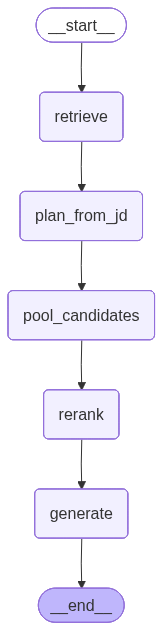

In [113]:
app

In [115]:
result_state = app.invoke({
    "query": "Give me the best candidate for the position of a junior business executive."
})
print("Recommendation:\n", result_state["answer"])
print("Top IDs:", result_state.get("ranked_ids", [])[:5])
print("Top scores:", [round(s, 4) for s in result_state.get("ranked_scores", [])[:5]])

Recommendation:
 Based on the provided information, **Candidate 2 (BUSINESS DEVELOPMENT SPECIALIST)** is the best match for a "junior business executive" position.

Here's the reasoning:

1.  **Role Alignment:** Candidate 2's primary roles, "Business Development Specialist" and "Sales Optimization Specialist," align well with the responsibilities typically expected of a junior business executive. These roles focus on hands-on execution, lead generation, supporting sales teams, and developing new business opportunities without necessarily carrying the strategic oversight of a director or senior manager.
2.  **Experience Level:** While Candidate 2 has strong accomplishments (e.g., generating significant pipeline and closed business, Microsoft M.V.P. awards), their titles and the nature of their tasks suggest a professional who is highly capable and results-driven but not yet at a senior leadership or director level. This fits the "junior" designation better than the other candidates.
3. 